In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import string
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from functools import reduce
from fractions import Fraction
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## Goals

* Convert documents into feature vectors.
* Use TF-IDF to get better vectors.
* Use document vectors to find similar documents.


## Setup

By now we're familiar with this idiom:

* Load feature matrix `X`, label vector `y`.
* Split, train, predict, evaluate, &c &c &c.

But what is your feature matrix `X` when your underlying sample data is a set of document? You need some way to turn **words** into **numbers**.

More technically, what you need is a **natural langauge processing feature extraction** pipeline.

An NLP pipeline converts a **list of documents** into a **list of feature vectors** of the same length. We have two main goals with this vector embedding:

* Similar documents should have near-by vectors (in some metric space).
* The vectors should perform well on prediction and classification tasks. (e.g., Sentiment analysis; subject classification.)

## Corpus: list of documents

Documents can vary wildly, from tweets to books. A document is a single cohesive work. Rule of thumb: any word in a document impacts the whole document.

In [2]:
corpus = ["Ride bikes every day.", 
          "Do bike wolves like to ride bikes?", 
          "'OUTTA MY WAY!', shouted The Bike Wolf.",
          "The Dow dropped 1000 points today."]

## Minimum Viable Product: Word Count Vector

The simplest thing possible: make a vocabulary of words. For each document, make a vector where the jth feature is the total count of the jth word.

### Split each document into terms

In [3]:
corpus_words = [x.split() for x in corpus]
corpus_words

[['Ride', 'bikes', 'every', 'day.'],
 ['Do', 'bike', 'wolves', 'like', 'to', 'ride', 'bikes?'],
 ["'OUTTA", 'MY', "WAY!',", 'shouted', 'The', 'Bike', 'Wolf.'],
 ['The', 'Dow', 'dropped', '1000', 'points', 'today.']]

### Derive a vocabulary

In [4]:
def get_vocab(corpus):
    vocab = reduce( lambda a,b: set(a)|set(b), corpus )
    return sorted(list(vocab))
vocab = get_vocab( corpus_words )
print( vocab )
print( "vocab len:", len(vocab) )

["'OUTTA", '1000', 'Bike', 'Do', 'Dow', 'MY', 'Ride', 'The', "WAY!',", 'Wolf.', 'bike', 'bikes', 'bikes?', 'day.', 'dropped', 'every', 'like', 'points', 'ride', 'shouted', 'to', 'today.', 'wolves']
vocab len: 23


### Convert documents into word count vector

In [5]:
m = len(corpus)
n = len(vocab)
X = np.zeros((m, n), dtype=int)

for i, doc_words in enumerate( corpus_words ):
    c = Counter(doc_words)
    X[ i, [vocab.index(w) for w in c.keys()] ] = list(c.values())

In [6]:
pd.DataFrame(X, columns=vocab)

,'OUTTA,1000,Bike,Do,Dow,MY,Ride,The,"WAY!',",Wolf.,...,day.,dropped,every,like,points,ride,shouted,to,today.,wolves
0,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
2,1,0,1,0,0,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0


### Some problems

The words "ride", "wolf", "bike" appeared more than once in different forms. We want a **pipeline** for processing our terms into standard forms.

## NLP Processing Pipeline

In [7]:
raw_docs = ["Ride bikes every day.", 
            "Do bike wolves like to ride bikes?", 
            "'OUTTA MY WAY!', shouted The Bike Wolf.",
            "The Dow dropped 1000 points today."]

### Convert to lower case

In [8]:
corpus = [x.lower() for x in raw_docs]
corpus

['ride bikes every day.',
 'do bike wolves like to ride bikes?',
 "'outta my way!', shouted the bike wolf.",
 'the dow dropped 1000 points today.']

### Split into tokens

In [9]:
corpus = [word_tokenize(x) for x in corpus]
corpus

[['ride', 'bikes', 'every', 'day', '.'],
 ['do', 'bike', 'wolves', 'like', 'to', 'ride', 'bikes', '?'],
 ["'outta", 'my', 'way', '!', "'", ',', 'shouted', 'the', 'bike', 'wolf', '.'],
 ['the', 'dow', 'dropped', '1000', 'points', 'today', '.']]

In [10]:
len(get_vocab(corpus))

25

### Drop punctuation

In [11]:
corpus = [[x for x in doc if x not in string.punctuation] for doc in corpus]
corpus

[['ride', 'bikes', 'every', 'day'],
 ['do', 'bike', 'wolves', 'like', 'to', 'ride', 'bikes'],
 ["'outta", 'my', 'way', 'shouted', 'the', 'bike', 'wolf'],
 ['the', 'dow', 'dropped', '1000', 'points', 'today']]

In [12]:
len(get_vocab(corpus))

20

### Drop Stop Words

In [13]:
stops = set(nltk.corpus.stopwords.words('english'))
print( stops )

{'were', 'needn', 'having', 'such', 'haven', 'from', 'only', 'than', 'both', 'just', 'aren', 'after', 'ourselves', 'you', 'in', 'all', 'shan', 'yourself', "shan't", 'nor', 'y', 'of', "she's", 'weren', 'had', 'can', 'each', 'ours', "you're", 'them', 'm', 'mightn', 'why', "that'll", 'through', "needn't", 'hers', 'a', 'shouldn', 'wasn', 'some', 'are', 'because', "didn't", 'ain', 'the', 'while', 'won', 'then', 'theirs', 'been', 'has', 'under', 'more', "couldn't", 'if', 'against', 'how', "shouldn't", 'be', 'have', "you'll", 'themselves', 'am', "aren't", 'now', 'any', "you've", 'own', 'do', 'they', 'he', 'o', 'she', "mightn't", 'into', 'yourselves', "haven't", "isn't", 'once', 'me', 'out', 'again', 'those', 'this', 'when', 'as', 'too', 'hadn', 't', 'what', 'll', "hasn't", 'd', 'up', "weren't", 'its', 'no', 'who', 'and', "mustn't", 'but', "doesn't", "don't", 'to', 'during', 've', 'couldn', 'will', 'itself', 'her', 'there', 'was', 's', "hadn't", 'ma', 'about', 'him', 'very', 'here', 'my', 'for

In [14]:
corpus = [[x for x in doc if x not in stops] for doc in corpus]
corpus

[['ride', 'bikes', 'every', 'day'],
 ['bike', 'wolves', 'like', 'ride', 'bikes'],
 ["'outta", 'way', 'shouted', 'bike', 'wolf'],
 ['dow', 'dropped', '1000', 'points', 'today']]

In [15]:
len(get_vocab(corpus))

16

### Find word stems (or lemmas)

A stemmer finds the word **stem**, which doesn't necessarily need to be a real word.

In [16]:
SnowballStemmer(language="english").stemmer.stem("is")

'is'

A lemmatizer finds a word's **lemma**, which is a real word.

In [17]:
WordNetLemmatizer().lemmatize("be")

'be'

In [18]:
stemmer = WordNetLemmatizer()
corpus = [[stemmer.lemmatize(x) for x in word] for word in corpus]
corpus

[['ride', 'bike', 'every', 'day'],
 ['bike', 'wolf', 'like', 'ride', 'bike'],
 ["'outta", 'way', 'shouted', 'bike', 'wolf'],
 ['dow', 'dropped', '1000', 'point', 'today']]

In [19]:
len(get_vocab(corpus))

14

## Count Vectorization Revisited

In [20]:
vocab = get_vocab(corpus)
print( vocab )

["'outta", '1000', 'bike', 'day', 'dow', 'dropped', 'every', 'like', 'point', 'ride', 'shouted', 'today', 'way', 'wolf']


In [21]:
m = len(corpus)
n = len(vocab)
X = np.zeros((m, n), dtype=int)

for i, doc_words in enumerate( corpus ):
    c = Counter(doc_words)
    X[ i, [vocab.index(w) for w in c.keys()] ] = list(c.values())

In [22]:
Xdf = pd.DataFrame( X, columns=vocab )
Xdf

,'outta,1000,bike,day,dow,dropped,every,like,point,ride,shouted,today,way,wolf
0,0,0,1,1,0,0,1,0,0,1,0,0,0,0
1,0,0,2,0,0,0,0,1,0,1,0,0,0,1
2,1,0,1,0,0,0,0,0,0,0,1,0,1,1
3,0,1,0,0,1,1,0,0,1,0,0,1,0,0


## Term frequency

Word's share **within the document**.

$$TF_{word,document} = \frac{\#\_of\_times\_word\_appears\_in\_document}{total\_\#\_of\_words\_in\_document}$$

First, find the total count of terms in each document.

In [23]:
Xdf

,'outta,1000,bike,day,dow,dropped,every,like,point,ride,shouted,today,way,wolf
0,0,0,1,1,0,0,1,0,0,1,0,0,0,0
1,0,0,2,0,0,0,0,1,0,1,0,0,0,1
2,1,0,1,0,0,0,0,0,0,0,1,0,1,1
3,0,1,0,0,1,1,0,0,1,0,0,1,0,0


In [24]:
n_terms = Xdf.sum(axis=1)
n_terms

0    4
1    5
2    5
3    5
dtype: int64

Normalize every term count by the total term count for that document.

In [25]:
tfdf = Xdf.apply( lambda col: [Fraction(a,b) for a,b in zip(col,n_terms)], axis=0 )
tfdf

,'outta,1000,bike,day,dow,dropped,every,like,point,ride,shouted,today,way,wolf
0,0,0,1/4,1/4,0,0,1/4,0,0,1/4,0,0,0,0
1,0,0,2/5,0,0,0,0,1/5,0,1/5,0,0,0,1/5
2,1/5,0,1/5,0,0,0,0,0,0,0,1/5,0,1/5,1/5
3,0,1/5,0,0,1/5,1/5,0,0,1/5,0,0,1/5,0,0


In [26]:
# NOTE NOTE above is for demonstration purposes only. A numpy operation makes more sense in practice:
N_col_vec = X.sum(axis=1).reshape(-1,1)
tf = X / N_col_vec
tf

array([[0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.  ,
        0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.4 , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.2 , 0.  ,
        0.  , 0.  , 0.2 ],
       [0.2 , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 ,
        0.  , 0.2 , 0.2 ],
       [0.  , 0.2 , 0.  , 0.  , 0.2 , 0.2 , 0.  , 0.  , 0.2 , 0.  , 0.  ,
        0.2 , 0.  , 0.  ]])

## Document frequency

Document Frequency is an expression of a term's prevalence **in the corpus**.

$$ DF_{word} = \frac{\#\_of\_documents\_containing\_word}{total\_\#\_of\_documents} $$

First, make a matrix where $x_{ij}$ is whether document $i$ contains term $j$.

In [27]:
term_appearance = (Xdf>0).astype(int)
term_appearance

,'outta,1000,bike,day,dow,dropped,every,like,point,ride,shouted,today,way,wolf
0,0,0,1,1,0,0,1,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
2,1,0,1,0,0,0,0,0,0,0,1,0,1,1
3,0,1,0,0,1,1,0,0,1,0,0,1,0,0


In [28]:
document_appearance = term_appearance.sum(axis=0)
document_appearance

'outta     1
1000       1
bike       3
day        1
dow        1
dropped    1
every      1
like       1
point      1
ride       2
shouted    1
today      1
way        1
wolf       2
dtype: int64

In [29]:
Xdfdf = document_appearance.map( lambda x: Fraction(x,len(corpus)) )
Xdfdf

'outta     1/4
1000       1/4
bike       3/4
day        1/4
dow        1/4
dropped    1/4
every      1/4
like       1/4
point      1/4
ride       1/2
shouted    1/4
today      1/4
way        1/4
wolf       1/2
dtype: object

Again, in practice a numpy operation makes more sense.

In [30]:
df = (X>0).sum(axis=0)/X.shape[0]
df

array([0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 , 0.25,
       0.25, 0.25, 0.5 ])

## Inverse document frequency

Inverse document frequency is a corpus-dependent measure of the importance of a word to a document. 

IDF encodes the intuition that less common words are more meaningful _to a single document_. For example, the word "grok" is very rare, so if you find it in a book, you can assume it is important to that book.

$$ IDF_{word} = \log\left(\frac{total\_\#\_of\_documents}{\#\_of\_documents\_containing\_word}\right) $$

In [31]:
idfdf = np.log( (1/Xdfdf).map( float ) )
idfdf

'outta     1.386294
1000       1.386294
bike       0.287682
day        1.386294
dow        1.386294
dropped    1.386294
every      1.386294
like       1.386294
point      1.386294
ride       0.693147
shouted    1.386294
today      1.386294
way        1.386294
wolf       0.693147
dtype: float64

In numpy:

In [32]:
idf = np.log(1/df)
idf

array([1.38629436, 1.38629436, 0.28768207, 1.38629436, 1.38629436,
       1.38629436, 1.38629436, 1.38629436, 1.38629436, 0.69314718,
       1.38629436, 1.38629436, 1.38629436, 0.69314718])

# TFIDF

So, we have a matrix of per-document term frequencies:

In [33]:
tfdf

,'outta,1000,bike,day,dow,dropped,every,like,point,ride,shouted,today,way,wolf
0,0,0,1/4,1/4,0,0,1/4,0,0,1/4,0,0,0,0
1,0,0,2/5,0,0,0,0,1/5,0,1/5,0,0,0,1/5
2,1/5,0,1/5,0,0,0,0,0,0,0,1/5,0,1/5,1/5
3,0,1/5,0,0,1/5,1/5,0,0,1/5,0,0,1/5,0,0


And we have a vector of the relative importance of terms.

In [34]:
idfdf

'outta     1.386294
1000       1.386294
bike       0.287682
day        1.386294
dow        1.386294
dropped    1.386294
every      1.386294
like       1.386294
point      1.386294
ride       0.693147
shouted    1.386294
today      1.386294
way        1.386294
wolf       0.693147
dtype: float64

In [35]:
tfidfdf = tfdf*idfdf
tfidfdf

,'outta,1000,bike,day,dow,dropped,every,like,point,ride,shouted,today,way,wolf
0,0,0,0.0719205,0.346574,0,0,0.346574,0,0,0.173287,0,0,0,0
1,0,0,0.115073,0,0,0,0,0.277259,0,0.138629,0,0,0,0.138629
2,0.277259,0,0.0575364,0,0,0,0,0,0,0,0.277259,0,0.277259,0.138629
3,0,0.277259,0,0,0.277259,0.277259,0,0,0.277259,0,0,0.277259,0,0


Now that we have turned our DOCUMENTS into VECTORS, we can put them into whatever machine learning algorithm we want! We can use whatever kind of similarity measure we please!

Wow!

## Interpretation

In [36]:
# normalize each tfidf row so that it's L2 norm is 1
tfidf = tf*idf
tfidf = (tfidf.T / np.linalg.norm(tfidf, axis=1)).T

In [37]:
tfidf_normalize_df = pd.DataFrame( tfidf, columns=vocab )

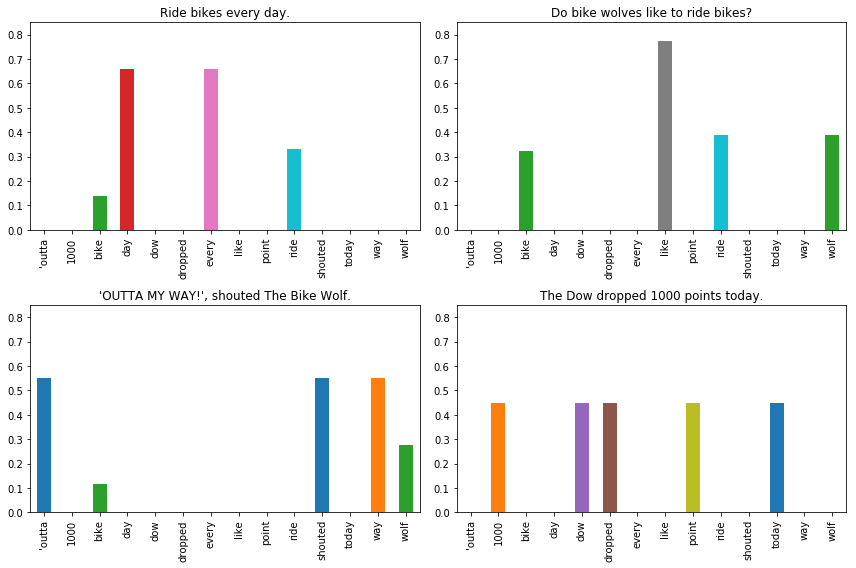

In [38]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    ax = axs.ravel()[i]
    ax.set_ylim(0,0.85)
    ax.set_title(raw_docs[i])
    tfidf_normalize_df.iloc[i].plot.bar(ax=ax)
plt.tight_layout()

## Cosine similarity

The cosine similarity between two vectors is

$$ \frac{\vec{u} \cdot \vec{v}}{||u||||v||} $$

But when $u$ and $v$ have a norm of 1, then cosine similarity is the dot product $u \cdot v$.

In [40]:
"ride bikes every day"
a = tfidf[0]
a

array([0.        , 0.        , 0.1370406 , 0.66037695, 0.        ,
       0.        , 0.66037695, 0.        , 0.        , 0.33018848,
       0.        , 0.        , 0.        , 0.        ])

In [41]:
raw_docs[1]

'Do bike wolves like to ride bikes?'

In [42]:
b = tfidf[1]
b

array([0.        , 0.        , 0.32094894, 0.        , 0.        ,
       0.        , 0.        , 0.77330105, 0.        , 0.38665053,
       0.        , 0.        , 0.        , 0.38665053])

In [44]:
a.dot(b) / (np.linalg.norm(a)*np.linalg.norm(b))

0.17165058340668266

In [38]:
#tfidf was normaized above, so the cosine similarity between 0 and 1 is:

#tfidf[0].dot( tfidf[1] )

0.17165058340668266

`sklearn.metrics.pairwise.cosine_similarity` will find a matrix of all pairwise cosine similarities.

In [39]:
cosim = cosine_similarity( tfidf, tfidf )

In [40]:
cosim[ cosim>0.9999 ] = np.NAN

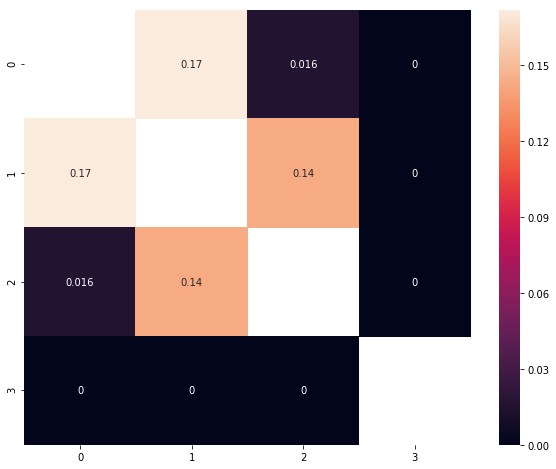

In [41]:
plt.figure(figsize=(10,8))
sns.heatmap(cosim, annot=True)

## Some debugging tips

### Autoreload

In [66]:
%load_ext autoreload
%autoreload 2

# after that, modules are reloaded automatically whenever they're changed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Catching and re-throwing an exception

In [75]:
# you didn't write this code. you got it from someone else. maybe it's a module.

def subroutine(a, b):
    # this should do something useful
    
    # but it doesn't
    
    raise Exception("a bad problem happened")

In [73]:
# you wrote this code. 

def foobar():
    a = 1+2
    b = a * 15
    
    try:                        #begin try block
        subroutine(a, b)        #put your code in here
    except Exception as ex:     #catch any exception that happens in the block
        
        # print out some information that's useful for debugging
        print( "our value of a is", a )
        print( "our value of b is", b )
        
        # Re-throw the exception
        # to continue as if you hadn't caught the exception.
        # You should do this, because an error in your code
        # _should_ result in your code failing.
        raise ex
    
    return b

In [74]:
foobar()

our value of a is 3
our value of b is 45


Exception: a bad problem happened